# Tree Image Segmentation by UNet 

In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import random
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

## Image Data Loader

In [14]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torchvision

annotation_folders = os.listdir('../../static/weecology-NeonTreeEvaluation/annotations')
def ImageLoader(path):
    img = datasets.folder.default_loader(path) # default loader
    # Get bounding box
    breed_folder = [x for x in annotation_folders if path.split('/')[-1].split('_')[0] in x][0]
    annotation_path = os.path.join('static/weecology-NeonTreeEvaluation/annotations', breed_folder, path.split('/')[-1][:-4])

    tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall('object')
    for obj in objects:
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
    bbox = (xmin, ymin, xmax, ymax)
    
    # return cropped image
    img = img.crop(bbox)
    img = img.resize((64, 64), Image.ANTIALIAS)
    return img



# Data Pre-procesing and Augmentation (Experiment on your own)
random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]

transform = transforms.Compose([
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# The dataset (example)
dataset = torchvision.datasets.ImageFolder(
    '../../static/weecology-NeonTreeEvaluation/evaluation/RGB/',
    loader=ImageLoader, # THE CUSTOM LOADER
    transform=transform
)

FileNotFoundError: Couldn't find any class folder in ../../static/weecology-NeonTreeEvaluation/evaluation/RGB/.

In [15]:
import os

directory = '../../static/weecology-NeonTreeEvaluation/evaluation/RGB/'
if not os.path.exists(directory):
    print(f"Directory {directory} does not exist.")
else:
    classes = [d.name for d in os.scandir(directory) if d.is_dir()]
    if not classes:
        print(f"No class folders found in {directory}.")
    else:
        print(f"Found class folders: {classes}")

No class folders found in ../../static/weecology-NeonTreeEvaluation/evaluation/RGB/.


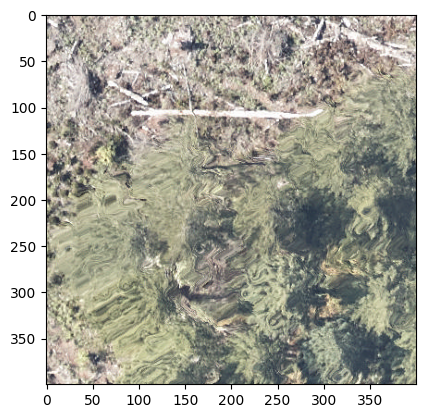

Training set size: 679
Validation set size: 135
Test set size: 92


In [8]:
# Load tif image from static/weecology-NeonTreeEvaluation/evaluation/RGB and split the folder to training, validation, and test sets (75%, 15%, 15%)

def load_tif_image(image_path):

    # Open the TIF file
    with rasterio.open(image_path) as src:
        # Read the image data
        image_data = src.read()

        # Display the image
        show(image_data)

def show_annotated_image(image_path, xml_path):
    # Load the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # Parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Iterate over all objects to find bounding boxes
    for obj in root.findall("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        
        # Extract bounding box coordinates
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        
        # Draw the bounding box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        draw.text((xmin, ymin), name, fill="red")
    
    # Show the annotated image
    image.show()


# split both data and annotations ('static/weecology-NeonTreeEvaluation/annotations') randomly into training, validation, and test sets
def split_data(image_paths, train_ratio=0.75, val_ratio=0.15):
    # Shuffle the image paths
    # set ranom seed for reproducibility
    random.seed(42)
    random.shuffle(image_paths)

    # Calculate the number of images for each set
    total_images = len(image_paths)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)

    # Split the data
    train_set = image_paths[:train_size]
    val_set = image_paths[train_size:train_size + val_size]
    test_set = image_paths[train_size + val_size:]

    return train_set, val_set, test_set

# Write a data loader function that reads the images and annotations from the specified paths and returns a batch of images and annotations
def data_loader(image_paths, annotation_paths, train_ratio, val_ratio, batch_size=32):
    # Combine the image and annotation paths
    data = list(zip(image_paths, annotation_paths))

    # Shuffle the data
    random.seed(42)
    random.shuffle(data)
    
    # Calculate the number of images for each set
    total_images = len(image_paths)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)

    # Split the data
    train_set = image_paths[:train_size]
    val_set = image_paths[train_size:train_size + val_size]
    test_set = image_paths[train_size + val_size:]
    
    # Iterate over the data in batches
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        images = []
        annotations = []
        for image_path, annotation_path in batch:
            # Load the image
            image = Image.open(image_path)
            images.append(image)
            
            # Load the annotation
            annotation = ET.parse(annotation_path)
            annotations.append(annotation)
        
        yield images, annotations
        
# Example usage
if __name__ == "__main__":
    # Define the path to the folder containing the TIF images
    data_path = "../../static/weecology-NeonTreeEvaluation/evaluation/RGB"
    annotation_path = "../../static/weecology-NeonTreeEvaluation/annotations"
    image = glob.glob(os.path.join(data_path, "*.tif"))
    annotation = glob.glob(os.path.join(annotation_path, "*.xml"))

    # Load training ratio
    train_ratio=0.75
    val_ratio=0.15
    
    # Load and display the first image
    load_tif_image(image[0])
    show_annotated_image(image[0], annotation[0])
    
    train_set, val_set, test_set = split_data(image)
    annotation_train_set, annotation_val_set, annotation_test_set = split_data(annotation)

    # Print the sizes of each set
    print(f"Training set size: {len(train_set)}")
    print(f"Validation set size: {len(val_set)}")
    print(f"Test set size: {len(test_set)}")

## UNet Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Define the contracting path (encoder)
        self.enc_conv1 = self.contracting_block(in_channels, 64)
        self.enc_conv2 = self.contracting_block(64, 128)
        self.enc_conv3 = self.contracting_block(128, 256)
        self.enc_conv4 = self.contracting_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.contracting_block(512, 1024)

        # Define the expansive path (decoder)
        self.upconv4 = self.expansive_block(1024, 512)
        self.upconv3 = self.expansive_block(512, 256)
        self.upconv2 = self.expansive_block(256, 128)
        self.upconv1 = self.expansive_block(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc_conv3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc_conv4(F.max_pool2d(enc3, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)

        return self.final_conv(dec1)

# Example usage
model = UNet(in_channels=3, out_channels=1)
print(model)

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc_conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0):

In [ ]:
import torch.optim as optim

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Example training loop
def train_model(model, dataloader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

# Assuming you have DataLoader named `train_loader`
# Uncomment and run this after setting up data loader and moving model to device
# train_model(model, train_loader)

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Thresholding

            # Display the image, true mask, and predicted mask
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[0].cpu().permute(1, 2, 0))  # Original image
            ax[1].imshow(masks[0].cpu().squeeze(), cmap='gray')  # True mask
            ax[2].imshow(preds[0].cpu().squeeze(), cmap='gray')  # Predicted mask
            plt.show()
            break  # Visualize one batch

# Uncomment to run visualization with a validation or test dataloader
# visualize_predictions(model, val_loader)